## COMIRI benchmarking analysis

In [142]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

Define functions for extracting results:

In [31]:
def update_gene_name(list_genes):
    if list_genes == [""]:
        return []
    else:
        return list(map(lambda x: x.split("*")[0], list_genes))

In [57]:
def verify_canonical(row, program):
    match = re.search(r"C[^_]*[FW]", row['cdr3aa_'+program])
    if not match:
        row['cdr3aa_'+program] = None
        row['cdr3dna_'+program] = None
    else:
        row['cdr3aa_'+program] = match.group()
        if program != "ImReP":
            row['cdr3dna_'+program] = row['cdr3dna_'+program][match.span()[0]*3:match.span()[1]*3]
    return row

In [33]:
# Implement more complex non-canonical: i.e. truncate but no delete vs truncate and delete vs no truncate and no delete

def merge_within(input_df, program, remove_missing_vjgene = True, remove_noncanonical = True):
    original_length = len(input_df)
    if remove_noncanonical:
        df_program = input_df.apply(verify_canonical, args=[program], axis=1)
        num_noncanonical = original_length - len(df_program)
    df_program.dropna(subset=['cdr3aa_'+program], inplace=True)
    df_program['cdr3dna_'+program] = df_program['cdr3dna_'+program].str.split(",")
    
    # Need to change this: J/V genes are lists, so need to check if they're empty
    # See: https://stackoverflow.com/questions/56903912/how-to-check-if-an-element-is-an-empty-list-in-pandas#:~:text=In%20Python%20the%20most%20efficient,would%20also%20work%20as%20expected.
    if remove_missing_vjgene:
        if program == "CATT":
            df_program = df_program[(~(df_program['Vgene_'+program].isnull()) | 
                            ~(df_program['Jgene_'+program].isnull()) ) & 
                            (df_program['cdr3aa_'+program].str.len() > 6)]
        else:
            df_program = df_program[~(df_program['Vgene_'+program].isnull()) & 
                                ~(df_program['Jgene_'+program].isnull()) & 
                                (df_program['cdr3aa_'+program].str.len() > 6)]
    df_program['count_'+program] = pd.to_numeric(df_program['count_'+program])
    dict_apply = {'count_'+program: "sum",
                    'Vgene_'+program: "sum",
                    'Dgene_'+program: "sum",
                    'Jgene_'+program: "sum",
                    'Cgene_'+program: "sum",
                    'cdr3dna_'+program: "sum"
    }
    df_program = df_program.groupby(['cdr3aa_'+program], as_index=False).agg(dict_apply)
    for column in ['Vgene_', 'Dgene_', 'Jgene_', 'Cgene_', 'cdr3dna_']:
        df_program[column+program] = df_program[column+program].apply(lambda row: list(set(row)))
    df_program['cdr3aa'] = df_program['cdr3aa_'+program]
    return df_program

In [58]:
dict_receptor = {"TCR": "T",
            "BCR-heavy": "IGH",
            "BCR-light": ("IGL", "IGK")}

In [34]:
def extract_MiXCR(filename, remove_missing_vjgene = True, remove_noncanonical = True):
    df_MiXCR = pd.read_csv(filename, sep="\t", usecols=["cloneCount",
                                                "allVHitsWithScore",
                                                "allDHitsWithScore",
                                                "allJHitsWithScore",
                                                "allCHitsWithScore",
                                                "nSeqCDR3",
                                                "aaSeqCDR3"],
                            header=0, dtype="object")
    df_MiXCR.columns = ["count_MiXCR", "Vgene_MiXCR", "Dgene_MiXCR", "Jgene_MiXCR",
                        "Cgene_MiXCR", "cdr3dna_MiXCR", "cdr3aa_MiXCR"]
    for gene in ["Vgene", "Dgene", "Jgene", "Cgene"]:
        df_MiXCR[gene+"_MiXCR"] = df_MiXCR[gene+"_MiXCR"].str.split(",")
        df_MiXCR.loc[df_MiXCR[gene+"_MiXCR"].isnull(),gene+"_MiXCR"] = df_MiXCR.loc[df_MiXCR[gene+"_MiXCR"].isnull(),gene+"_MiXCR"].apply(lambda x: [])
        df_MiXCR[gene+"_MiXCR"] = df_MiXCR[gene+"_MiXCR"].apply(update_gene_name)
    df_MiXCR_merged = merge_within(df_MiXCR, "MiXCR", remove_missing_vjgene, remove_noncanonical)
    return df_MiXCR_merged

In [35]:
def extract_TRUST3(filename, remove_missing_vjgene = True, remove_noncanonical = True):
    with open(filename, "r") as fasta_file:
        lines_fasta = fasta_file.readlines()
        list_output = []
        for line in lines_fasta:
            if line.startswith(">"):
                list_line = [element.replace(">", "").replace("|", "").replace("\n", "").split("=")[-1]
                                for element in line.split("+")
                                if (not element.startswith("est_clonal_exp=")
                                    and not element.startswith("seq_length=")
                                    and not element.startswith("minus_log_Eval=")
                                    and not element.startswith("est_lib_size="))]
                list_reportgene = list(map(lambda x: x.split("*")[0].replace("/", ""), list_line[4].split("_")))
                list_line[2] = list(set([gene.split("*")[0].replace("/", "") for gene in list_line[2].split("_") if gene != ""]
                                    + list(filter(lambda gene: gene[3] == 'V', list_reportgene))))
                list_line[3] = list(set([gene.split("*")[0].replace("/", "") for gene in list_line[3].split("_") if gene != ""]
                                    + list(filter(lambda gene: gene[3] == 'J', list_reportgene))))
                list_line.pop(4)
                list_line = list_line[1:] + [[], []]
                list_output.append(list_line)
    df_TRUST3 = pd.DataFrame(list_output, columns=['count_TRUST3', 'Vgene_TRUST3', 'Jgene_TRUST3',
                                                'cdr3aa_TRUST3', 'cdr3dna_TRUST3', 'Dgene_TRUST3',
                                                'Cgene_TRUST3'],
                                dtype="object")
    df_TRUST3_merged = merge_within(df_TRUST3, "TRUST3", remove_missing_vjgene, remove_noncanonical)
    return df_TRUST3_merged

In [59]:
def extract_TRUST4(filename, receptor, remove_missing_vjgene = True, remove_noncanonical = True):
    df_TRUST4_all = pd.read_csv(filename, sep="\t", usecols=['#count', 'CDR3nt',
                                                            'CDR3aa', 'V', 'D', 'J', 'C'])
    df_TRUST4 = df_TRUST4_all[df_TRUST4_all[['V','J','C','D']].apply(lambda x: x.str.startswith(dict_receptor[receptor])).any(axis=1)]
    df_TRUST4 = df_TRUST4[df_TRUST4.CDR3aa != "out_of_frame"]
    df_TRUST4.columns = ["count_TRUST4", "cdr3dna_TRUST4", "cdr3aa_TRUST4",
                        "Vgene_TRUST4", "Dgene_TRUST4", "Jgene_TRUST4", "Cgene_TRUST4"]
    for gene in ["Vgene", "Dgene", "Jgene", "Cgene"]:
        df_TRUST4[gene+"_TRUST4"].replace(to_replace=".", value="", inplace=True)
        df_TRUST4[gene+"_TRUST4"] = df_TRUST4[gene+"_TRUST4"].str.split(",")
        df_TRUST4[gene+"_TRUST4"] = df_TRUST4[gene+"_TRUST4"].apply(update_gene_name)
    df_TRUST4_merged = merge_within(df_TRUST4, "TRUST4", remove_missing_vjgene, remove_noncanonical)
    return df_TRUST4_merged

In [37]:
def fix_CATT_gene_name(gene_str):
    if gene_str == "None":
        gene_str = ""
    if "|" in gene_str:
        return gene_str.split("|")[1]
    else:
        return gene_str

def extract_CATT(filename, receptor, remove_missing_vjgene = True, remove_noncanonical = True):
    if receptor == "TRA":
        df_CATT = pd.read_csv(filename, sep=",", usecols=['AAseq', 'NNseq', 'Vregion',
                                                        'Jregion', 'Dregion', 'Frequency'])
        df_CATT.columns = ["cdr3aa_CATT", "cdr3dna_CATT", "Vgene_CATT", "Jgene_CATT",
                            "Dgene_CATT", "count_CATT"]
        df_CATT["Cgene_CATT"] = ""
    else:
        df_CATT = pd.read_csv(filename, sep=",", usecols=['AAseq', 'NNseq', 'Vregion',
                                                        'Jregion', 'Frequency'])
        df_CATT.columns = ["cdr3aa_CATT", "cdr3dna_CATT", "Vgene_CATT", "Jgene_CATT",
                            "count_CATT"]
        df_CATT["Dgene_CATT"] = ""
        df_CATT["Cgene_CATT"] = ""
    for gene in ["Vgene", "Dgene", "Jgene", "Cgene"]:
        df_CATT[gene+"_CATT"] = df_CATT[gene+"_CATT"].apply(fix_CATT_gene_name)
        df_CATT[gene+"_CATT"] = df_CATT[gene+"_CATT"].str.split(",")
        df_CATT[gene+"_CATT"] = df_CATT[gene+"_CATT"].apply(update_gene_name)
    df_CATT_merged = merge_within(df_CATT, "CATT", remove_missing_vjgene, remove_noncanonical)
    return df_CATT_merged

In [60]:
def extract_ImReP(filename, receptor, remove_missing_vjgene = True, remove_noncanonical = True):
    df_ImReP = pd.read_csv(filename, usecols=['CDR3_AA_Seq', 'Read_count', 'V_chains',
                                            'D_chains', 'J_chains'])
    df_ImReP.columns = ["cdr3aa_ImReP", "count_ImReP", "Vgene_ImReP",
                        "Dgene_ImReP", "Jgene_ImReP"]
    df_ImReP = df_ImReP[df_ImReP[['Vgene_ImReP','Dgene_ImReP','Jgene_ImReP']].apply(lambda x: x.str.startswith(dict_receptor[receptor])).any(axis=1)]
    df_ImReP["Cgene_ImReP"] = ""
    df_ImReP["cdr3dna_ImReP"] = ""
    for gene in ["Vgene", "Dgene", "Jgene", "Cgene"]:
        df_ImReP[gene+"_ImReP"].fillna("", inplace = True)
        df_ImReP[gene+"_ImReP"] = df_ImReP[gene+"_ImReP"].str.split(";")
        df_ImReP[gene+"_ImReP"] = df_ImReP[gene+"_ImReP"].apply(update_gene_name)
    df_ImReP = df_ImReP.dropna(subset=["cdr3aa_ImReP"], axis=0)
    df_ImReP_merged = merge_within(df_ImReP, "ImReP", remove_missing_vjgene, remove_noncanonical)
    return df_ImReP_merged

### BCR-heavy analysis:

Extract and clean results from each algorithm:

In [70]:
samples = ["FZ-20", "FZ-83", "FZ-94", "FZ-97", "FZ-116", "FZ-122"]

dict_sample_names = {
    "SRR7882935": "FZ-122",
    "SRR7882936": "FZ-116",
    "SRR7882937": "FZ-97",
    "SRR7882938": "FZ-94",
    "SRR7882939": "FZ-83",
    "SRR7882940": "FZ-20"
}

dict_file_suffix = {
    "TRUST3": ".Aligned.sortedByCoord.out.bam-BCR-HeavyChain.fa",
    "TRUST4": "_report.tsv",
    "MiXCR": "_BCR-heavy_clones.txt",
    "CATT": ".IGH.CDR3.CATT.csv",
    "ImReP": "_BCR-light-heavy.txt"
}

dict_method = {
    "TRUST3": extract_TRUST3,
    "TRUST4": extract_TRUST4,
    "MiXCR": extract_MiXCR,
    "CATT": extract_CATT,
    "ImReP": extract_ImReP
}

dict_results = {}

for sample in dict_sample_names.keys():
    dict_results[dict_sample_names[sample]] = {}
    for method in dict_method.keys():
        if method in ["TRUST4", "CATT", "ImReP"]:
            dict_results[dict_sample_names[sample]][method] = dict_method[method](os.path.join("BCR_2022",method,sample+dict_file_suffix[method]), "BCR-heavy")
        else:
            dict_results[dict_sample_names[sample]][method] = dict_method[method](os.path.join("BCR_2022",method,sample+dict_file_suffix[method]))
        

Extract BCR-seq data (gold standard):

In [90]:
def extract_BCRseq(filename):
    df_BCRseq = pd.read_csv(filename, usecols=["CDR3(pep)", "copy"])
    df_BCRseq.columns = ["cdr3aa", "count"]
    df_BCRseq = df_BCRseq.groupby(["cdr3aa"], as_index=False).sum()
    df_BCRseq.dropna(inplace=True)
    df_BCRseq = df_BCRseq[~df_BCRseq["cdr3aa"].str.contains("\*")]
    return df_BCRseq

In [91]:
for sample in samples:
    dict_results[sample]["BCRseq"] = extract_BCRseq(os.path.join("BCR_2022", "BCRseq",sample+".csv"))

Merge results from different algorithms:

In [78]:
for sample in samples:
    dict_results[sample]["merged"] = dict_results[sample]["TRUST3"]
    for algorithm in ["TRUST4", "MiXCR", "CATT", "ImReP"]:
        dict_results[sample]["merged"] = dict_results[sample]["merged"].merge(dict_results[sample][algorithm], how="outer", on="cdr3aa")

Get results from quorum voting:

In [118]:
def quorum(row, list_algorithms, num_votes):
    return ["Y" if isinstance(row["cdr3aa_"+algorithm], str) else "N" for algorithm in list_algorithms].count("Y") >= num_votes

dict_algorithms = {"BCR-heavy": ["MiXCR", "TRUST3", "TRUST4", "CATT", "ImReP"],
                    "BCR-light": ["MiXCR", "TRUST3", "TRUST4", "ImReP"],
                    "TCR": ["MiXCR", "TRUST3", "TRUST4", "CATT", "ImReP"]}

for sample in samples:
    for q in [2, 3, 4, 5]:
        dict_results[sample]["quorum"+str(q)] = dict_results[sample]["merged"][dict_results[sample]["merged"].apply(lambda row: quorum(row, dict_algorithms["BCR-heavy"], q), axis=1)]

Get 90th quantile CDR3s from BCR-seq data:

In [115]:
for sample in samples:
    BCRseq_quantile = dict_results[sample]["BCRseq"]["count"].quantile([0.9])
    dict_results[sample]["BCRseq_quantile"] = dict_results[sample]["BCRseq"][dict_results[sample]["BCRseq"]["count"] >= BCRseq_quantile[0.9]]

Merge with BCRseq to find overlap with gold standard:

In [125]:
dict_benchmarking_metrics = {}
list_methods = ["TRUST3", "TRUST4", "MiXCR", "CATT", "ImReP",
                "merged", "quorum2", "quorum3", "quorum4", "quorum5"]

for sample in samples:
    for method in list_methods:
        dict_results[sample][method].loc[:, "cdr3aa_truncated"] = dict_results[sample][method].loc[:, "cdr3aa"].str.slice(start=1, stop=-1)
        dict_benchmarking_metrics[method+"_"+sample] = {
            "len_total": len(dict_results[sample][method]),
            "len_merge_BCRseq": len(dict_results[sample][method].merge(dict_results[sample]["BCRseq"], left_on="cdr3aa_truncated", right_on="cdr3aa", how="inner")),
            "len_merge_BCRseq_quantile": len(dict_results[sample][method].merge(dict_results[sample]["BCRseq_quantile"], left_on="cdr3aa_truncated", right_on="cdr3aa", how="inner")),
            "len_BCRseq": len(dict_results[sample]["BCRseq"]),
            "len_BCRseq_quantile": len(dict_results[sample]["BCRseq_quantile"])
        }

/Users/jbreynier/opt/anaconda3/envs/ml4h_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Benchmarking calculations:

In [137]:
df_benchmarking_metrics = pd.DataFrame.from_dict(dict_benchmarking_metrics)
df_benchmarking_metrics = df_benchmarking_metrics.transpose()
df_benchmarking_metrics["method"] = df_benchmarking_metrics.index.to_series().str.split("_").str[0]
df_benchmarking_metrics["sample"] = df_benchmarking_metrics.index.to_series().str.split("_").str[1]
df_benchmarking_metrics.reset_index(inplace=True, drop=True)
df_benchmarking_metrics["quantile_recall"] = df_benchmarking_metrics["len_merge_BCRseq_quantile"] / df_benchmarking_metrics["len_BCRseq_quantile"]
df_benchmarking_metrics["total_recall"] = df_benchmarking_metrics["len_merge_BCRseq"] / df_benchmarking_metrics["len_BCRseq"]
df_benchmarking_metrics["precision"] = df_benchmarking_metrics["len_merge_BCRseq"] / df_benchmarking_metrics["len_total"]
df_benchmarking_metrics["method"] = df_benchmarking_metrics["method"].replace("merged", "quorum1")
df_benchmarking_metrics

,len_total,len_merge_BCRseq,len_merge_BCRseq_quantile,len_BCRseq,len_BCRseq_quantile,method,sample,quantile_recall,total_recall,precision
0,2193,1272,823,40247,4060,TRUST3,FZ-20,0.202709,0.031605,0.580027
1,6204,3391,1936,40247,4060,TRUST4,FZ-20,0.476847,0.084255,0.546583
2,4143,2748,1685,40247,4060,MiXCR,FZ-20,0.415025,0.068278,0.663287
3,2522,1470,927,40247,4060,CATT,FZ-20,0.228325,0.036524,0.582871
4,1374,1006,682,40247,4060,ImReP,FZ-20,0.167980,0.024996,0.732169
5,7205,3550,1983,40247,4060,quorum1,FZ-20,0.488424,0.088205,0.492713
6,4654,2928,1765,40247,4060,quorum2,FZ-20,0.434729,0.072751,0.629136
7,2857,2008,1294,40247,4060,quorum3,FZ-20,0.318719,0.049892,0.702835
8,1356,1077,754,40247,4060,quorum4,FZ-20,0.185714,0.026760,0.794248
9,364,324,257,40247,4060,quorum5,FZ-20,0.063300,0.008050,0.890110


Plots for sample FZ-20:


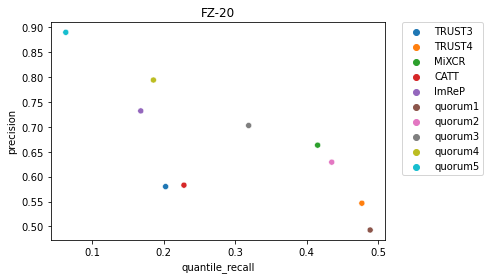

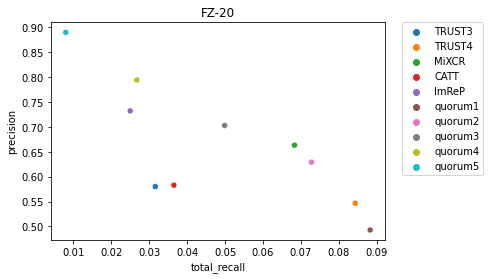

Plots for sample FZ-83:


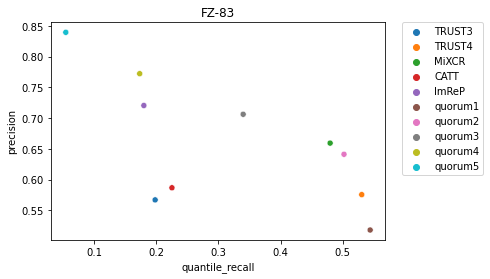

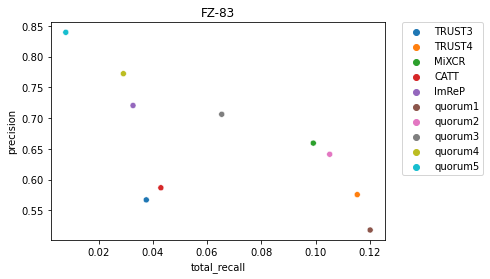

Plots for sample FZ-94:


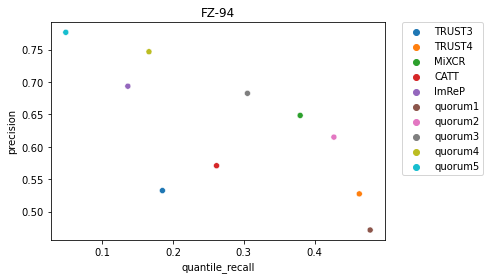

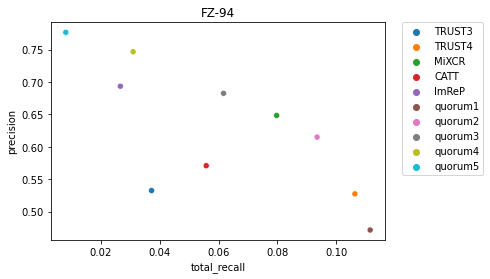

Plots for sample FZ-97:


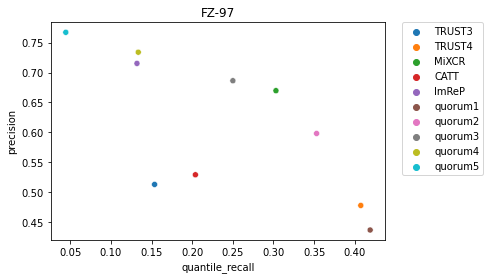

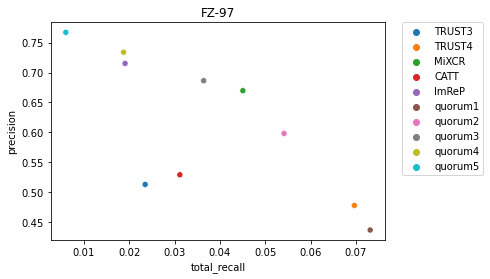

Plots for sample FZ-116:


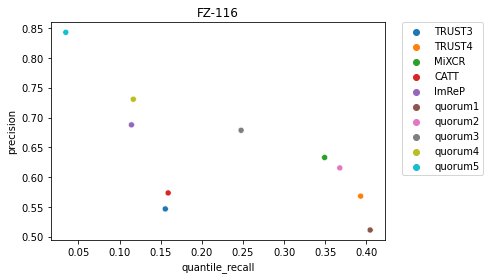

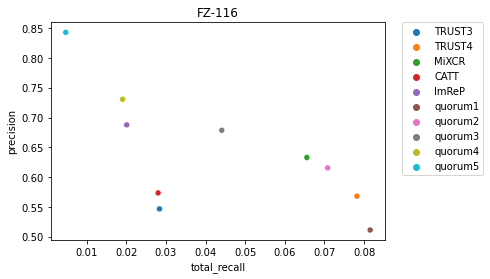

Plots for sample FZ-122:


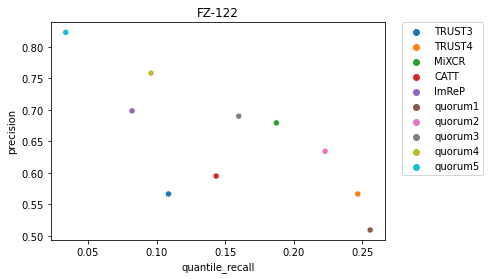

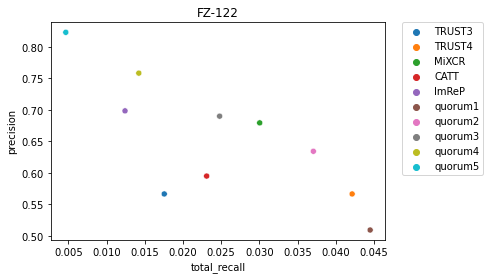

In [151]:
for sample in samples:
    print(f"Plots for sample {sample}:")
    df_benchmarking_metrics_sample = df_benchmarking_metrics.loc[df_benchmarking_metrics["sample"] == sample,:]
    sns.scatterplot(x="quantile_recall", y='precision', data=df_benchmarking_metrics_sample, hue='method')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(sample)
    plt.show()

    sns.scatterplot(x="total_recall", y='precision', data=df_benchmarking_metrics_sample, hue='method')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(sample)
    plt.show()


Average for all BCR samples:

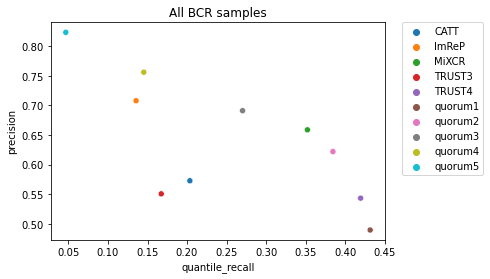

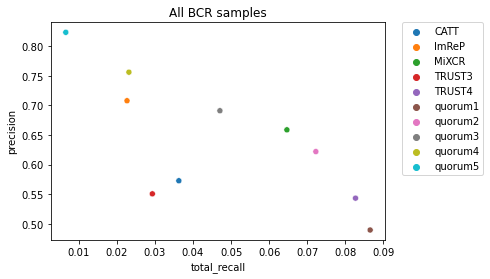

In [155]:
df_benchmarking_metrics_average = df_benchmarking_metrics.groupby(["method"])[["quantile_recall", "total_recall", "precision"]].mean()

sns.scatterplot(x="quantile_recall", y='precision', data=df_benchmarking_metrics_average, hue='method')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title("All BCR samples")
plt.show()

sns.scatterplot(x="total_recall", y='precision', data=df_benchmarking_metrics_average, hue='method')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title("All BCR samples")
plt.show()

Max scaling:

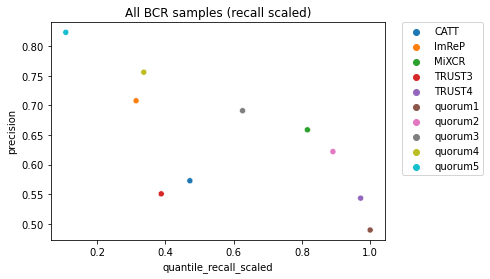

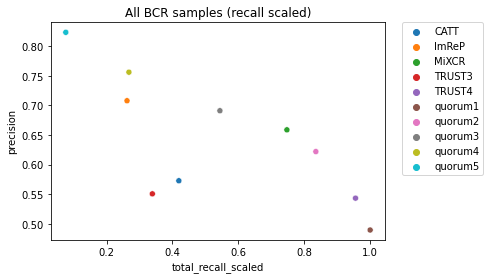

In [156]:
df_benchmarking_metrics_average["quantile_recall_scaled"] = df_benchmarking_metrics_average["quantile_recall"] / df_benchmarking_metrics_average["quantile_recall"].max()
df_benchmarking_metrics_average["total_recall_scaled"] = df_benchmarking_metrics_average["total_recall"] / df_benchmarking_metrics_average["total_recall"].max()

sns.scatterplot(x="quantile_recall_scaled", y='precision', data=df_benchmarking_metrics_average, hue='method')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title("All BCR samples (recall scaled)")
plt.show()

sns.scatterplot(x="total_recall_scaled", y='precision', data=df_benchmarking_metrics_average, hue='method')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title("All BCR samples (recall scaled)")
plt.show()